In [ ]:
%%capture
#@markdown # DeepLab inference
!python -m pip install abraia
!python -m pip install onnxruntime

import os
if not os.getenv('ABRAIA_ID') and not os.getenv('ABRAIA_KEY'):
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

from abraia import Multiple

multiple = Multiple()

circles/*.{png,jpg}
circles/img_199.png
{'task': 'segment', 'inputShape': [1, 3, 128, 128], 'classes': ['circle']}
circles/img_199.png [{'label': 'circle', 'confidence': 0.9606869220733643, 'box': [67.13153600692749, 23.663557469844818, 93.73035192489624, 50.90367704629898], 'color': '#D0021B', 'polygon': [(70, 24), (68, 26), (67, 26), (67, 46), (68, 46), (70, 48), (70, 49), (72, 49), (73, 50), (73, 51), (87, 51), (87, 50), (88, 49), (90, 49), (90, 48), (92, 46), (93, 46), (93, 26), (92, 26), (90, 24)]}]


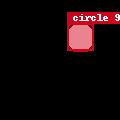

In [ ]:
from PIL import Image, ImageDraw, ImageFont

import onnxruntime as ort
import numpy as np
import math
import cv2
import re


def get_color(idx):
    colors = ['#D0021B', '#F5A623', '#F8E71C', '#8B572A', '#7ED321',
    '#417505', '#BD10E0', '#9013FE', '#4A90E2', '#50E3C2', '#B8E986',
    '#000000', '#545454', '#737373', '#A6A6A6', '#D9D9D9', '#FFFFFF']
    return colors[idx % len(colors)]

def hex_to_rgb(hex):
    h = hex.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def load_image(path):
    return Image.open(multiple.cache_file(path))

def resize(img, size):
    width = size if img.height > img.width else round(size * img.width / img.height)
    height = round(size * img.height / img.width) if img.height > img.width else size
    return img.resize((width, height))

def crop(img, size):
    left, top = (img.width - size) // 2, (img.height - size) // 2
    right, bottom = left + size, top + size
    return img.crop((left, top, right, bottom))

def normalize(img, mean, std):
    img = (np.array(img) / 255. - np.array(mean)) / np.array(std)
    return img.astype(np.float32)

def preprocess(img):
    img = img.convert('RGB')
    img = resize(img, 256)
    img = crop(img, 224)
    img = normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return np.expand_dims(img.transpose((2, 0, 1)), axis=0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(outputs, classes):
    probs = softmax(outputs[0].flatten())
    idx = np.argmax(probs)
    results = [{'label': classes[idx], 'confidence': probs[idx], 'color': get_color(idx)}]
    return results


def prepare_input(img, shape):
    """Converts the input image to RGB an return a (3, height, width) tensor."""
    img = img.convert("RGB")
    img = img.resize((shape[3], shape[2]))
    input = np.array(img) / 255.0
    input = input.transpose(2, 0, 1)
    input = input.reshape(shape)
    return input.astype(np.float32)

def intersection(box1, box2):
    """Calculates the intersection area of two boxes."""
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2
    x1, y1 = max(box1_x1, box2_x1), max(box1_y1, box2_y1)
    x2, y2 = min(box1_x2, box2_x2), min(box1_y2, box2_y2)
    return (x2 - x1) * (y2 - y1)

def union(box1, box2):
    """Calculates the union area of two boxes."""
    box1_x1, box1_y1, box1_x2, box1_y2 = box1
    box2_x1, box2_y1, box2_x2, box2_y2 = box2
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    return box1_area + box2_area - intersection(box1, box2)

def iou(box1, box2):
    """Calculates "Intersection-over-union" coefficient for specified two boxes."""
    return intersection(box1, box2) / union(box1, box2)

def sigmoid_mask(z):
    mask = 1 / (1 + np.exp(-z))
    return 255 * (mask > 0.5).astype('uint8')

def get_mask(row, box, img_width, img_height):
    """Extracts the segmentation mask for an object (box) in a row."""
    size = round(math.sqrt(row.shape[0]))
    mask = row.reshape(size, size)
    mask = sigmoid_mask(mask)
    x1, y1, x2, y2 = box
    mask_x1, mask_y1 = round(x1 / img_width * size), round(y1 / img_height * size)
    mask_x2, mask_y2 = round(x2 / img_width * size), round(y2 / img_height * size)
    mask = mask[mask_y1:mask_y2, mask_x1:mask_x2]
    img_mask = Image.fromarray(mask, "L")
    img_mask = img_mask.resize((round(x2-x1), round(y2-y1)))
    mask = np.array(img_mask)
    return mask

def get_polygon(mask, origin):
    """Calculates the bounding polygon based on the segmentation mask."""
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygon = [[int(contour[0][0]), int(contour[0][1])] for contour in contours[0][0]]
    polygon = [(int(origin[0] + point[0]), int(origin[1] + point[1])) for point in polygon]
    return polygon

def process_output(outputs, size, shape, classes):
    """Converts the RAW model output from YOLOv8 to an array of detected
    objects, containing the bounding box, label and the probability.
    """
    img_width, img_height = size
    model_width, model_height = shape[3], shape[2]
    output0 = outputs[0][0].astype("float")
    output0 = output0.transpose()
    if len(outputs) == 2:
        output1 = outputs[1][0].astype("float")
        output1 = output1.reshape(output1.shape[0], output1.shape[1] * output1.shape[2])

    objects = []
    for row in output0:
        xc, yc, w, h = row[:4]
        probs = row[4:4+len(classes)]
        idx = probs.argmax()
        if probs[idx] < 0.5:
            continue
        x1, y1 = (xc - w/2) / model_width * img_width, (yc - h/2) / model_height * img_height
        x2, y2 = (xc + w/2) / model_width * img_width, (yc + h/2) / model_height * img_height
        obj = {'label': classes[idx], 'confidence': probs[idx], 'box': [x1, y1, x2, y2], 'color': get_color(idx)}
        if len(outputs) == 2:
            obj['mask'] = row[4+len(classes):]
        objects.append(obj)

    objects.sort(key=lambda x: x['confidence'], reverse=True)
    results = []
    while len(objects) > 0:
        results.append(objects[0])
        objects = [obj for obj in objects if iou(obj['box'], objects[0]['box']) < 0.5]

    for result in results:
        if len(outputs) == 2:
            mask = result['mask'] @ output1
            mask = get_mask(mask, (x1, y1, x2, y2), img_width, img_height)
            result['polygon'] = get_polygon(mask, (x1, y1))
            result.pop('mask', None)
    return results


def render_results(img, results):
    draw = ImageDraw.Draw(img, "RGBA")
    for result in results:
        x1, y1 = 0, 0
        label = result.get('label')
        prob = result.get('confidence')
        color = hex_to_rgb(result.get('color'))
        if (label):
            if result.get('polygon'):
                draw.polygon(result['polygon'], fill=(color[0], color[1], color[2], 125), outline=color, width=1)
            if result.get('box'):
                [x1, y1, x2, y2] = result['box']
                draw.rectangle([(x1, y1), (x2, y2)], outline=color, width=2)
            text = f" {label} {round(100 * prob, 1)}% "
            font = ImageFont.load_default()
            y1 = max(y1 - 11, 0)
            bbox = draw.textbbox((x1, y1), text, font=font)
            draw.rectangle(bbox, fill=color)
            draw.text((x1, y1), text, font=font)
    return img


class Model:
    def load_model(self, dataset, model_name):
        self.config = multiple.load_json(f"{dataset}/{model_name}.json")
        model_src = multiple.cache_file(f"{dataset}/{model_name}.onnx")
        self.ort_session = ort.InferenceSession(model_src, providers=['CPUExecutionProvider'])

    def run_model(self, img):
        print(self.config)
        if self.config.get('task'):
            input = prepare_input(img, self.config['inputShape'])
            outputs = self.ort_session.run(None, {"images": input})
            return process_output(outputs, img.size, self.config['inputShape'], self.config['classes'])
        input = preprocess(img)
        outputs = self.ort_session.run(None, {"input": input})
        results = postprocess(outputs, self.config['classes'])
        return results


dataset = 'screws'
model_name = 'model_ft'
dataset = 'circles'
model_name = 'yolov8n-seg'
print(f"{dataset}/*.{{png,jpg}}")

files = multiple.list_files(f"{dataset}/*.png")[0]
path = files[0]['path']
src = os.path.basename(path)
print(path)

model = Model()
model.load_model(dataset, model_name)

img = load_image(path).convert('RGB')
results = model.run_model(img)
print(path, results)

img = render_results(img, results)
img